# Detection using Trained networks

In [1]:
#Imports

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import cv2

import collections

# This is needed if the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

#if tf.__version__ < '1.4.0':
  #raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

#imports from object-detection module
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

In [2]:
# Variables

# Path to frozen detection graph. This is the actual model that is used for the object detection. Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
PATH_TO_CKPT = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/boxDetector_V2_multiclass/try2-withCaseObject-newData/result_minScore05_ckpt-11150/output_inference_graph/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/media/hooman/hsSsdPartUbuntu/FM_PROJECT/FMDL_3.1/backhoe/boxDetector_V2_multiclass/try2-withCaseObject-newData/hs_label_map_multiclass_withCase.pbtxt'

NUM_CLASSES = 5
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

## Helper code

In [16]:
#Load a (frozen) Tensorflow model into memory

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        
graph = detection_graph

In [31]:
#Path to test images and labels
imagesPath = '/home/hooman/Desktop/i2lData_cropped/Orapa/'
labelsPath = '/home/hooman/dataPreparation/hsTestSet/labels/'
savedResultsPath = '/home/hooman/Desktop/i2lData_cropped/OrapaCr/'

In [32]:
#load the label map

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [33]:
#Loading test images

TEST_IMAGE_PATHS = []
TEST_IMAGE_IDS = []

for fileName in os.listdir(imagesPath):
    TEST_IMAGE_IDS.append(fileName)
    TEST_IMAGE_PATHS.append(imagesPath + fileName)

## Helper methods

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
# To time an op put it under     with timeit()
class timeit():
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

In [9]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                            tensor_name)
                
                
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                
                
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                                         feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [10]:
def hsGetPredictedBoundingBox(boxes, classes, scores, min_score_thresh, max_boxes_to_draw=20):
  box_to_color_map = collections.defaultdict(str)

  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
    
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    box = tuple()
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
        
      box_to_color_map[box] = 'LightGreen'
        
    return box_to_color_map

In [11]:
def thresholdPredictions(boxes, classes, scores, score_threshold_bucket, score_threshold_matInside, score_threshold_case):
        bucketBoundary = tuple()
        bucketScore = -1

        matInsideBoundary = tuple()
        matInsideScore = -1
        
        caseBoundary = tuple()
        caseScore = -1

        for i in range(boxes.shape[0]):
            box = tuple()

            if (classes[i] == 1 and scores[i] >= score_threshold_bucket) \
            or(classes[i] == 2 and scores[i] >= score_threshold_matInside)\
            or(classes[i] == 3 and scores[i] >= score_threshold_case):

                box = tuple(boxes[i].tolist())

                if classes[i]==1 and scores[i] > score_threshold_bucket: #this is a bucket BB
                    if scores[i] > bucketScore:
                        bucketBoundary = box
                        bucketScore = scores[i]

                if classes[i]==2 and scores[i ]> score_threshold_matInside: #this is a matInside BB
                    if scores[i] > matInsideScore:
                        matInsideBoundary = box
                        matInsideScore = scores[i]
                        
                        
                if classes[i]==3 and scores[i ]> score_threshold_case: #this is a case BB
                    if scores[i] > caseScore:
                        caseBoundary = box
                        matInsideScore = scores[i]

        return bucketBoundary, bucketScore, matInsideBoundary, matInsideScore, caseBoundary, caseScore

In [12]:
def hsPredict(image_path, min_score_thresh=0.5):
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    selectedBoundingBoxes = hsGetPredictedBoundingBox(
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      min_score_thresh)
    
    return selectedBoundingBoxes, image_np

In [13]:
def hsDisplayPrediction(boundingBoxes, image_np):
    for box, color in boundingBoxes.items():
        ymin, xmin, ymax, xmax = box

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=4,
        display_str_list='',
        use_normalized_coordinates=True)

    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [14]:
def writeRowsToCsv(rows, csvFullPath):
    # open the file
    csv_file = open(csvFullPath, "w") 
    
    # define column names
    columnTitles = "filename,pathname,xmins,xmax,ymins,ymax,class\n"
    csv_file.write(columnTitles)

    # write rows
    for row in rows:
        csv_file.write(row)

    csv_file.close()
    
    print("wrote " + str(len(rows)) + " to csv file\n")

## Peforming Predictions and Saving Results to Disk

### Backhoe:

In [ ]:
### multi image whole process: Load, Test, Display
scoreToUse = 0.9

for filePath, fileName in zip(TEST_IMAGE_PATHS, TEST_IMAGE_IDS):

    image = Image.open(filePath)


    STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = detection_graph

    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)


            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]



    boxes   = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores  = output_dict['detection_scores']





    box_to_color_map = collections.defaultdict(str)
    box_to_display_str_map = collections.defaultdict(list)



    for i in range(boxes.shape[0]):
        box = tuple()


        if scores is None or scores[i] > scoreToUse:
            box = tuple(boxes[i].tolist())

            #box_to_color_map[box] = 'LightGreen'
            box_to_color_map[box] = STANDARD_COLORS[classes[i]]


            display_str = ''
            if classes[i] in category_index.keys():
                class_name = category_index[classes[i]]['name']
            display_str = str(class_name)

            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
            box_to_display_str_map[box].append(display_str)




    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box

        vis_util.draw_bounding_box_on_image_array(
            image_np,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=4,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=True)

    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    
    #import cv2
    #cv2.imwrite( savedResultsPath + fileName, image_np)


### Hydraulics and Cable:

In [25]:
### MULTI image whole process: Load, Test, Display
#image = cv2.imread('/home/hooman/backhoeOpticalScene/testData/1_20180704-205500_1001n0_870.png')

for imgName in os.listdir(imagesPath):
    image = Image.open(imagesPath + imgName)


    STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = detection_graph

    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)


            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]



    boxes   = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores  = output_dict['detection_scores']





    box_to_color_map = collections.defaultdict(str)
    box_to_display_str_map = collections.defaultdict(list)



    for i in range(boxes.shape[0]):
        box = tuple()


        if scores is None or scores[i] > 0.9: #0.001  0.0001:
            box = tuple(boxes[i].tolist())

            #box_to_color_map[box] = 'LightGreen'
            box_to_color_map[box] = STANDARD_COLORS[classes[i]]


            display_str = ''
            if classes[i] in category_index.keys():
                class_name = category_index[classes[i]]['name']
            display_str = str(class_name)

            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
            box_to_display_str_map[box].append(display_str)




    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box

        vis_util.draw_bounding_box_on_image_array(
            image_np,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=4,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=True)

    #plt.figure(figsize=IMAGE_SIZE)
    #plt.imshow(image_np)
    cv2.imwrite(savedResultsPath + imgName, image_np)

(480, 720, 3)


In [ ]:
### Single image whole process: Load, Test, Display
#image = cv2.imread('/home/hooman/backhoeOpticalScene/testData/1_20180704-205500_1001n0_870.png')
image = Image.open('/home/hooman/randd/MachineLearning/TeamMembers/Bhuvan/boulderNew/images/1004_OpHydra_ESP_day_6Hour_159611_20.png')


STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

image_np = load_image_into_numpy_array(image)
image_np_expanded = np.expand_dims(image_np, axis=0)

graph = detection_graph

with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)


        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
        
        
        
boxes   = output_dict['detection_boxes']
classes = output_dict['detection_classes']
scores  = output_dict['detection_scores']





box_to_color_map = collections.defaultdict(str)
box_to_display_str_map = collections.defaultdict(list)



for i in range(boxes.shape[0]):
    box = tuple()
    
    
    if scores is None or scores[i] > 0.9: #0.001  0.0001:
        box = tuple(boxes[i].tolist())

        #box_to_color_map[box] = 'LightGreen'
        box_to_color_map[box] = STANDARD_COLORS[classes[i]]
        
        
        display_str = ''
        if classes[i] in category_index.keys():
            class_name = category_index[classes[i]]['name']
        display_str = str(class_name)
        
        display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        box_to_display_str_map[box].append(display_str)

        


for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=4,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=True)

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

#### same as above but seperately:

In [10]:
# Load Image

#image = Image.open(TEST_IMAGE_PATHS[1])1_20161115-124600_0001n0_0    
image = Image.open('/home/hooman/visualizing-LayerActivations-in-DeepNetworks/FMDL_2018.05.25_05.23.06.png')



image_np = load_image_into_numpy_array(image)
image_np_expanded = np.expand_dims(image_np, axis=0)

In [20]:
#FeedForward
    
with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        #print(ops)


        all_tensor_names = {output.name for op in ops for output in op.outputs}
        #print(all_tensor_names)

        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)

                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


        with timeit():
            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})


        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]
            

runtime: 0:00:02.506941


In [ ]:
#Display

boxes   = output_dict['detection_boxes']
classes = output_dict['detection_classes']
scores  = output_dict['detection_scores']





box_to_color_map = collections.defaultdict(str)

max_boxes_to_draw = boxes.shape[0]

for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    box = tuple()
    
    if scores is None or scores[i] > 0.9: #0.001  0.0001:
      box = tuple(boxes[i].tolist())

      box_to_color_map[box] = 'LightGreen'

        
boundingBoxes = box_to_color_map





for box, color in boundingBoxes.items():
    ymin, xmin, ymax, xmax = box

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=4,
        display_str_list='',
        use_normalized_coordinates=True)

    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

## Crop the images with boudnary

In [34]:
# Crop the images with boudnary
for imgName in os.listdir(imagesPath):
    image = Image.open(imagesPath + imgName)


    STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = detection_graph

    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)


            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]



    boxes   = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores  = output_dict['detection_scores']


    bucketBoundary, bucketScore, matInsideBoundary, matInsideScore, _, _ = thresholdPredictions(boxes, classes, scores, 0.001, 0.001, 0.001)


    
    
    if len(matInsideBoundary)>3:
        ymin, xmin, ymax, xmax = matInsideBoundary
    else:
        ymin, xmin, ymax, xmax = bucketBoundary
    
    
    
    
    '''
    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color='LightGreen',
        thickness=4,
        display_str_list='sd',
        use_normalized_coordinates=True)

    
    plt.imshow(image_np)
    plt.show()
    '''

    
    
    
    
    
    
    
    image_h, image_w, _ = image_np.shape

    xmin_g = int(xmin * image_w)
    xmax_g = int(xmax * image_w)
    ymin_g = int(ymin * image_h)
    ymax_g = int(ymax * image_h)


    if ymin_g != -1 and xmin_g != -1 and ymax_g != 1000 and xmax_g != 1000:
        #plt.imshow( image_np[int(ymin_g):int(ymax_g), int(xmin_g):int(xmax_g), :] )
        #plt.show()
        cv2.imwrite(savedResultsPath + imgName, image_np[int(ymin_g):int(ymax_g), int(xmin_g):int(xmax_g), :])


# Visualizing the network

## Visualizing the activations (i.e response to an input)

In [12]:
#FeedForward only to the last layer of ssd backbone
    
with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        #print(ops)


        all_tensor_names = {output.name for op in ops for output in op.outputs}
        #print(all_tensor_names)

        tensor_dict = {}
        
        #key = 'FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_10_pointwise/Conv2D'
        key = 'FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_1_pointwise/Relu6'
        tensor_name = key + ':0'
        
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


        # Run inference
        output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})


        # all outputs are float32 numpy arrays, so convert types as appropriate
        #output_dict['detection_scores'] = output_dict['detection_scores'][0]
        k = output_dict[key][0]
  
            
k.shape        

(320, 320, 64)

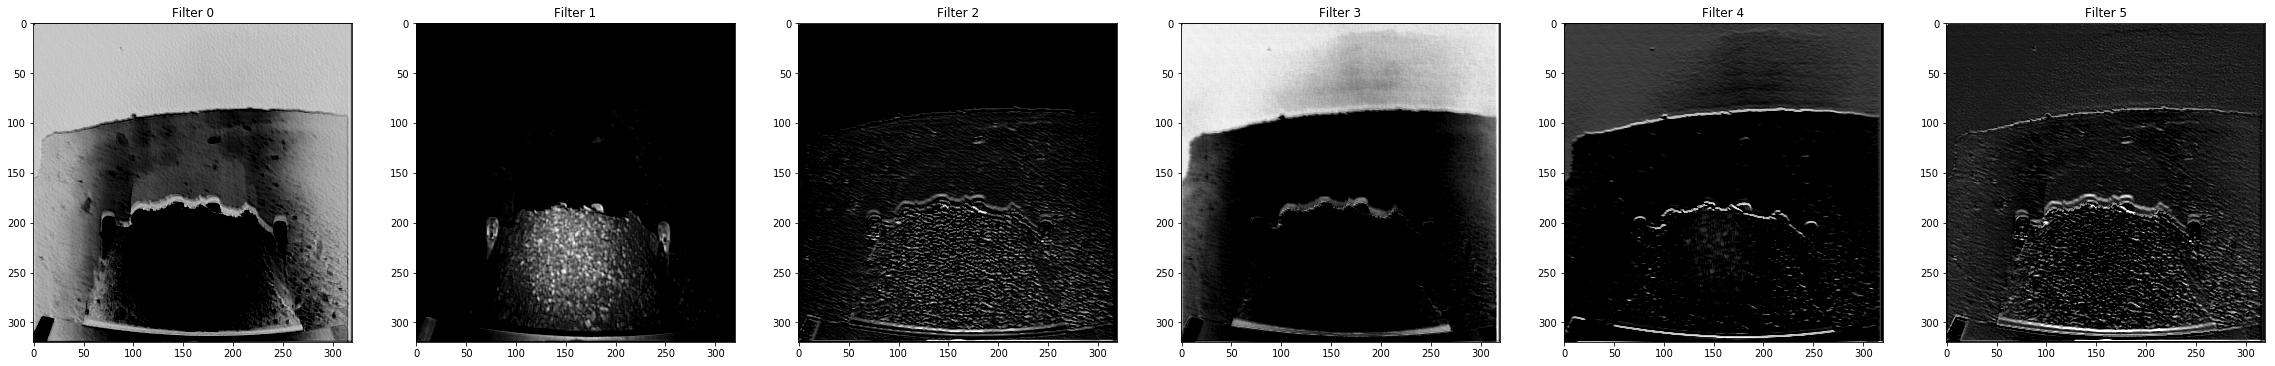

In [74]:
# Plotting the extracted feature map
plt.figure(1, figsize=(40,40))
n_columns = 6
n_rows = 1
for i in range(6):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(k[:,:,i], interpolation="nearest", cmap="gray")

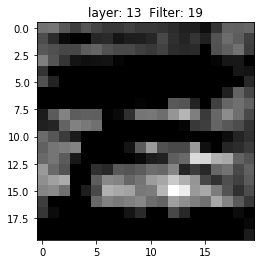

In [23]:
# extracting and saving activations of all layers
outdir = '/home/hooman/Downloads/ssdActivationsPrinted/'

layerNamesDic = {}
for x in range(1,14):
    layerNamesDic[x] = 'FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_' + str(x) + '_pointwise/Relu6'


with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in layerNamesDic.values():
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)


        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})



        
for nb in layerNamesDic.keys():
    k = output_dict[layerNamesDic[nb]][0]
    
    for i in range(20):
        plt.title('layer: ' + str(nb) + '  Filter: ' + str(i))
        plt.imshow(k[:,:,i], interpolation="nearest", cmap="gray")
        plt.savefig(outdir + 'layer' + str(nb) + '/' + 'layer_' + str(nb) + '__filter_' + str(i) +'.png')

## Visualizing a networks weights

In [ ]:
#FeedForward only to the last layer of ssd backbone
    
with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        #print(ops)


        all_tensor_names = {output.name for op in ops for output in op.outputs}
        #print(all_tensor_names)

        tensor_dict = {}
        
        key = 'FeatureExtractor/MobilenetV1/Conv2d_1_pointwise/weights'
        
        tensor_name = key + ':0'
        
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')


        # Run inference
        output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})


        # all outputs are float32 numpy arrays, so convert types as appropriate
        #output_dict['detection_scores'] = output_dict['detection_scores'][0]
        k = output_dict[key][0]
  
            
print(k.shape)  
plt.imshow(k[0,:,:], interpolation="nearest", cmap="gray")

In [ ]:
#same above

import tensorflow as tf
import numpy as np
from tensorflow.python import pywrap_tensorflow
from matplotlib import pyplot as plt



with graph.as_default():
    with tf.Session() as sess:
        weightArray=sess.run('FeatureExtractor/MobilenetV1/Conv2d_1_pointwise/weights:0')
        print(weightArray.shape)
        
        
        #weightArray = weightArray.reshape(-1,1,32,3)
        x_min = np.min(weightArray)
        x_max = np.max(weightArray)
        wing=255.0*(weightArray.squeeze() - x_min) / (x_max - x_min)
        plt.imshow(wing.astype('uint8'), cmap="gray")
        plt.axis('off')

# <font color='red'> Sandbox Area

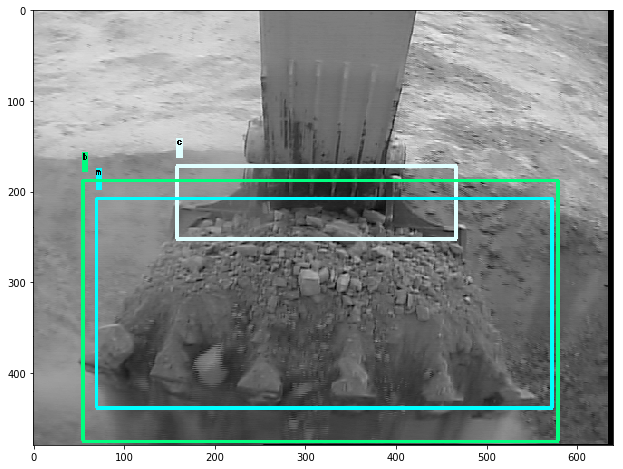

In [24]:

scoreToUse = 0.1

filePath = '/media/hooman/New Volume/FM_PROJECT_STORAGE/QC-Tests/backhoe/Telfer_hydraulics_backhoe/FMDL/3chan/FMDL_2018.10.04_14.54.20.png'
fileName = 'FMDL_2018.10.04_14.54.20.png'


image = Image.open(filePath)


STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

image_np = load_image_into_numpy_array(image)
image_np_expanded = np.expand_dims(image_np, axis=0)

graph = detection_graph

with graph.as_default():
    with tf.Session() as sess:
        # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
              tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)


        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
            output_dict['detection_masks'] = output_dict['detection_masks'][0]



boxes   = output_dict['detection_boxes']
classes = output_dict['detection_classes']
scores  = output_dict['detection_scores']






bucketBoundary, bucketScore, matInsideBoundary, matInsideScore, caseBoundary, caseScore = thresholdPredictions(boxes, classes, scores, 0.5, 0.5, 0.5)

box_to_color_map = collections.defaultdict(str)
box_to_display_str_map = collections.defaultdict(list)


if len(caseBoundary) > 3:
    ymin, xmin, ymax, xmax = caseBoundary

    
    display_str = 'case'
    display_str = '{}: {}%'.format(display_str, int(100*caseScore))

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=STANDARD_COLORS[3],
        thickness=4,
        display_str_list=display_str,
        use_normalized_coordinates=True)
    
    
    
    
if len(matInsideBoundary) > 3:
    ymin, xmin, ymax, xmax = matInsideBoundary

    display_str = 'matInside'
    display_str = '{}: {}%'.format(display_str, int(100*matInsideScore))

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=STANDARD_COLORS[2],
        thickness=4,
        display_str_list=display_str,
        use_normalized_coordinates=True)
    
    
    
    
    
if len(bucketBoundary) > 3:
    ymin, xmin, ymax, xmax = bucketBoundary

    display_str = 'bucket'
    display_str = '{}: {}%'.format(display_str, int(100*bucketScore))

    vis_util.draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=STANDARD_COLORS[1],
        thickness=4,
        display_str_list=display_str,
        use_normalized_coordinates=True)
    
    
    
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)


#import cv2
#cv2.imwrite( savedResultsPath + fileName, image_np)


In [ ]:
# Crop the images with boudnary
for imgName in os.listdir(imagesPath):
    image = Image.open(imagesPath + imgName)


    STANDARD_COLORS = ['LightGoldenRodYellow', 'SpringGreen', 'Aqua', 'LightCyan']

    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)

    graph = detection_graph

    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)


            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]



    boxes   = output_dict['detection_boxes']
    classes = output_dict['detection_classes']
    scores  = output_dict['detection_scores']





    box_to_color_map = collections.defaultdict(str)
    box_to_display_str_map = collections.defaultdict(list)



    for i in range(boxes.shape[0]):
        box = tuple()


        if scores is None or scores[i] > 0.01: #0.001  0.0001:
            box = tuple(boxes[i].tolist())

            #box_to_color_map[box] = 'LightGreen'
            box_to_color_map[box] = STANDARD_COLORS[classes[i]]


            display_str = ''
            if classes[i] in category_index.keys():
                class_name = category_index[classes[i]]['name']
            display_str = str(class_name)

            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
            box_to_display_str_map[box].append(display_str)



    ymin_g = -1
    xmin_g = -1
    ymax_g = 10000
    xmax_g = 10000
    image_h, image_w, _ = image_np.shape
    
    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box
        
        xmin = int(xmin * image_w)
        xmax = int(xmax * image_w)
        ymin = int(ymin * image_h)
        ymax = int(ymax * image_h)
        
        
        
     
        if ymin > ymin_g:
            ymin_g = ymin
            
        if xmin > xmin_g:
            xmin_g = xmin
            
            
        if ymax < ymax_g:
            ymax_g = ymax
            
        if xmax < xmax_g:
            xmax_g = xmax
            
        
        
    print(xmin_g)
    print(ymin_g)
    print(xmax_g)
    print(ymax_g)

    
    if ymin_g != -1 and xmin_g != -1 and ymax_g != 1000 and xmax_g != 1000:
        cv2.imwrite(savedResultsPath + imgName, image_np[int(ymin_g):int(ymax_g),int(xmin_g):int(xmax_g),:])

In [ ]:
# Peforming Predictions and Saving Results to CSV
#This just gets the bucket 

rows = []
for filePath, fileName in zip(TEST_IMAGE_PATHS, TEST_IMAGE_IDS):
    bBoxes, imOut = hsPredict(filePath, 0.9)
    
    if len(bBoxes) <= 0:
        print("found NO bounding boxes:  ", filePath, "\n")
        row = fileName + "," + filePath + "," + "" +","+ "" + "," + "" + "," + "" + "," + "bucket" + "\n"
    
    else:
        if len(bBoxes) > 1:
            print("found MULTIPLE bounding boxes, but ONLY took the first one:  ", filePath, "\n")
        
        norm_ymin, norm_xmin, norm_ymax, norm_xmax = bBoxes.popitem()[0]
        
        (im_height, im_width) = (imOut.shape[0], imOut.shape[1])
        
        (xmin, xmax, ymin, ymax) = (norm_xmin * im_width, norm_xmax * im_width,norm_ymin * im_height, norm_ymax * im_height)
        
        row = fileName + "," + filePath + "," + str(xmin) +","+ str(xmax) + "," + str(ymin) + "," + str(ymax) + "," + "bucket" + "\n"
        
    rows.append(row)
    
writeRowsToCsv(rows, "/home/hooman/backhoeOpticalScene/try2_ssdMultiClass_withInappInMatInside/result_minScore09_ckpt-115973/outputImages_score50/try2_ssdMultiClass_withInappInMatInside_score50.csv")

In [ ]:
#making predictions
for image_path in TEST_IMAGE_PATHS[0:4]:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [ ]:
# hs this cell contains everything you need to run hsGetPredictedBoundingBox

import collections
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
  """Adds a bounding box to an image (numpy array).

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))
    
    
    
    
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.

  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.

  Each string in display_str_list is displayed on a separate line above the
  bounding box in black text on a rectangle filled with the input 'color'.
  If the top of the bounding box extends to the edge of the image, the strings
  are displayed below the bounding box.

  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin

In [ ]:
def hsGetPredictedBoundingBox(
    boxes,
    classes,
    scores,
    category_index,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    groundtruth_box_visualization_color='black',
    skip_scores=False,
    skip_labels=False):

  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
    
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
    
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in category_index.keys():
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(int(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, int(100*scores[i]))
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]
        
    return box_to_color_map

In [ ]:
#making predictions

image_path = TEST_IMAGE_PATHS[1]

image = Image.open(image_path)

# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)

# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)

# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)

hsBB = hsGetPredictedBoundingBox(
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  use_normalized_coordinates=True,
  line_thickness=8)

In [ ]:
#displaying results

for box, color in hsBB.items():
    ymin, xmin, ymax, xmax = box

    draw_bounding_box_on_image_array(
        image_np,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=4,
        display_str_list='',
        use_normalized_coordinates=True)

plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)